Using the Mauna Lua CO2 dataset (monthly) perform forecasting using an MLP and compare the results with that of MA (Moving Average) and ARMA (Auto Regressive Moving Average)  models. Main setting: use previous “K” readings to predict next “T” reading. Example, if “K=3” and “T=1” then we use data from Jan, Feb, March and then predict the reading for April. Comment on why you observe such results. For MA or ARMA you can use any library or implement it from scratch. The choice of MLP is up to you. [2 marks]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

In [4]:
muana_df = pd.read_csv("co2_mm_mlo.csv", comment="#")
muana_df

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99
...,...,...,...,...,...,...,...,...
787,2023,10,2023.7917,418.82,422.12,27,0.47,0.17
788,2023,11,2023.8750,420.46,422.46,21,0.91,0.38
789,2023,12,2023.9583,421.86,422.58,20,0.68,0.29
790,2024,1,2024.0417,422.80,422.45,27,0.73,0.27


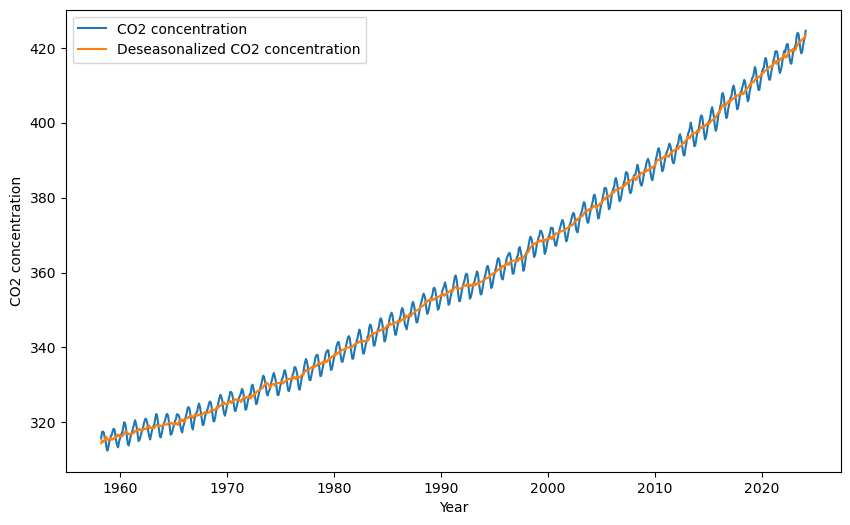

In [5]:
# plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(data=muana_df, x="decimal date", y="average", label="CO2 concentration")
sns.lineplot(data=muana_df, x="decimal date", y="deseasonalized", label="Deseasonalized CO2 concentration")
plt.xlabel("Year")
plt.ylabel("CO2 concentration")
plt.legend()
plt.show()

In [6]:
def create_lagged_dataset(data, K, T):
    X, Y = [], []
    for i in range(len(data) - K - T + 1):
        X.append(data[i:(i+K)])
        Y.append(data[(i+K):(i+K+T)])
    return np.array(X), np.array(Y)

In [7]:
from torch import nn, optim

class MLP(nn.Module):

    def __init__(self, input_dim, output_dim):
        size = 128 # affects the performance of the model
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, size),
            nn.ReLU(),
            # nn.Linear(size, 32),
            # nn.ReLU(),
            nn.Linear(size, output_dim),
        )

    def forward(self, x):
        return self.layers(x)

def train_mlp(X, Y, epochs=200):
    model = MLP(X.shape[1], Y.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    for epoch in range(epochs):
        inputs = torch.from_numpy(X).float()
        targets = torch.from_numpy(Y).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    return model

In [49]:
from statsmodels.tsa.arima.model import ARIMA

# def train_ma(data, order=(0, 0, 1)):
#     model = ARIMA(data, order=order)
#     model_fit = model.fit()
#     return model_fit

# def train_arma(data, order=(2, 0, 1)):
#     model = ARIMA(data, order=order)
#     model_fit = model.fit()
#     return model_fit

def forecast_ma(data, K, T, order=(0,0,1)):
    # for loop to forecast next T steps from K steps using MA model
    forecasts = []
    i = 0
    # for i in range(0, len(data) - K - T + 1):
    while i < len(data) - K - T + 1:
        model = ARIMA(data[i:(i+K)], order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=T)
        i = i + T
        forecasts.append(forecast)

    # insert first K data to the beginning of the forecast
    forecasts = np.insert(forecasts, 0, data[:K])
    return np.array(forecasts).flatten()

def forecast_arma(data, K, T, order=(1,0,2)):
    # for loop to forecast next T steps from K steps using ARMA model
    forecasts = []
    i = 0
    # for i in range(0, len(data) - K - T + 1):
    while i < len(data) - K - T + 1:
        model = ARIMA(data[i:(i+K)], order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=T)
        i = i + T
        forecasts.append(forecast)

    forecasts = np.insert(forecasts, 0, data[:K])
    return np.array(forecasts).flatten()

    

In [50]:
K = 3
T = 1
X, Y = create_lagged_dataset(muana_df[["decimal date", "average"]].values, K, T)

# split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# X_train[:, :, 1], Y_train[:, :, 1]
X.shape, Y.shape

((789, 3, 2), (789, 1, 2))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# train the models
mlp_model = train_mlp(X_train[:, :, 1], Y_train[:, :, 1])
# ma_model = train_ma(muana_df["average"])
# arma_model = train_arma(muana_df["average"])

# forecast the models
# mlp_forecast = mlp_model(torch.from_numpy(X_test).float()).detach().numpy()
ma_forecast = forecast_ma(muana_df["average"], K, T)
arma_forecast = forecast_arma(muana_df["average"], K, T)

# ma_forecast, arma_forecast

In [52]:
# make predictions
mlp_predictions = mlp_model(torch.from_numpy(X_test[:,:,1]).float()).detach().numpy()
mlp_predictions_with_decimal_date = np.column_stack((X_test[:, -1, 0], mlp_predictions[:,0]))

# ma_predictions = ma_model.predict(start=train_size, end=len(muana_df)-1)
# ma_predictions_with_decimal_date = np.column_stack((muana_df["decimal date"][train_size:], ma_predictions))

# arma_predictions = arma_model.predict(start=train_size, end=len(muana_df)-1)
# arma_predictions_with_decimal_date = np.column_stack((muana_df["decimal date"][train_size:], arma_predictions))

ma_forecast_with_decimal_date = np.column_stack((muana_df["decimal date"], ma_forecast))
arma_forecast_with_decimal_date = np.column_stack((muana_df["decimal date"], arma_forecast))

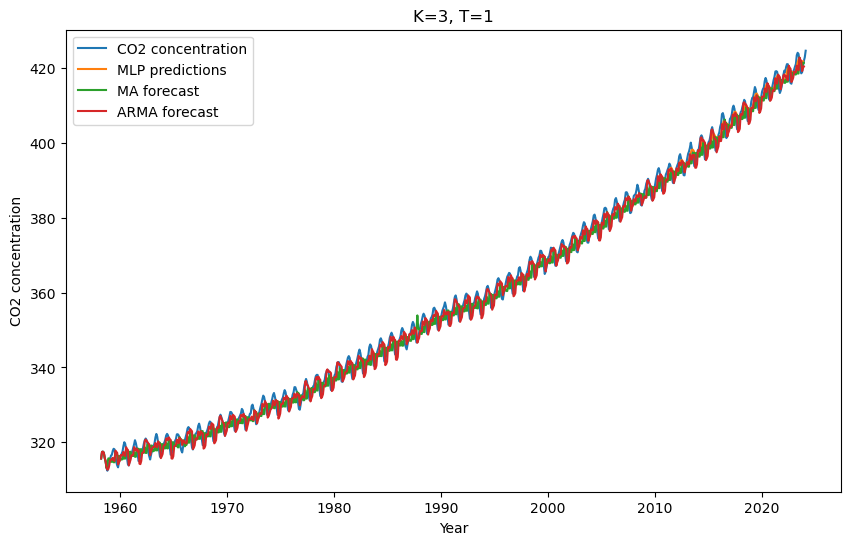

In [85]:
# plot predictions
plt.figure(figsize=(10, 6))
sns.lineplot(data=muana_df, x="decimal date", y="average", label="CO2 concentration")
sns.lineplot(data=pd.DataFrame(mlp_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MLP predictions")
# sns.lineplot(data=pd.DataFrame(ma_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MA predictions")
# sns.lineplot(data=pd.DataFrame(arma_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="ARMA predictions")
sns.lineplot(data=pd.DataFrame(ma_forecast_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MA forecast")
sns.lineplot(data=pd.DataFrame(arma_forecast_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="ARMA forecast")
plt.xlabel("Year")
plt.ylabel("CO2 concentration")
plt.title("K=3, T=1")
plt.legend()
plt.show()

In [55]:
# calculate the mean squared error
from sklearn.metrics import mean_squared_error

mlp_mse = mean_squared_error(Y_test[:, :, 1], mlp_predictions)
# ma_mse = mean_squared_error(muana_df["average"][train_size:], ma_predictions)
# arma_mse = mean_squared_error(muana_df["average"][train_size:], arma_predictions)

ma_mse = mean_squared_error(muana_df["average"], ma_forecast)
arma_mse = mean_squared_error(muana_df["average"], arma_forecast)

mlp_mse, ma_mse, arma_mse

(6.738606008680839, 7.038376007770063, 4.826344684158432)

In [68]:
K = 10
T = 5
X, Y = create_lagged_dataset(muana_df[["decimal date", "average"]].values, K, T)

# split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# X_train[:, :, 1], Y_train[:, :, 1]
X.shape, Y.shape

((778, 10, 2), (778, 5, 2))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# train the models
mlp_model = train_mlp(X_train[:, :, 1], Y_train[:, :, 1])
# ma_model = train_ma(muana_df["average"])
# arma_model = train_arma(muana_df["average"])

# forecast the models
# mlp_forecast = mlp_model(torch.from_numpy(X_test).float()).detach().numpy()
ma_forecast = forecast_ma(muana_df["average"], K, T)
arma_forecast = forecast_arma(muana_df["average"], K, T)

# ma_forecast, arma_forecast

In [73]:
# make predictions
mlp_predictions = mlp_model(torch.from_numpy(X_test[:,:,1]).float()).detach().numpy()
mlp_predictions_with_decimal_date = np.column_stack((X_test[:, -1, 0], mlp_predictions[:,0]))

# ma_predictions = ma_model.predict(start=train_size, end=len(muana_df)-1)
# ma_predictions_with_decimal_date = np.column_stack((muana_df["decimal date"][train_size:], ma_predictions))

# arma_predictions = arma_model.predict(start=train_size, end=len(muana_df)-1)
# arma_predictions_with_decimal_date = np.column_stack((muana_df["decimal date"][train_size:], arma_predictions))

max_len = min(len(muana_df), len(ma_forecast))
ma_forecast_with_decimal_date = np.column_stack((muana_df["decimal date"][:max_len], ma_forecast[:max_len]))
arma_forecast_with_decimal_date = np.column_stack((muana_df["decimal date"][:max_len], arma_forecast[:max_len]))

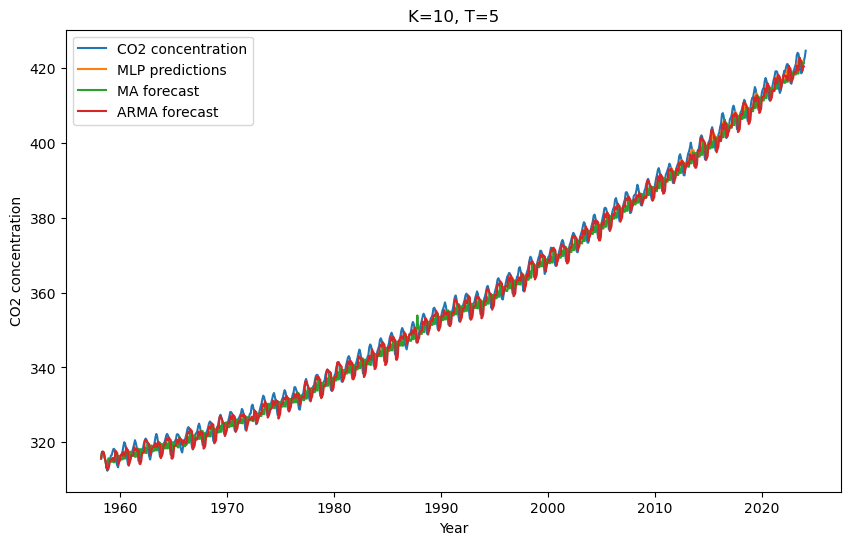

In [84]:
# plot predictions
plt.figure(figsize=(10, 6))
sns.lineplot(data=muana_df, x="decimal date", y="average", label="CO2 concentration")
sns.lineplot(data=pd.DataFrame(mlp_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MLP predictions")
# sns.lineplot(data=pd.DataFrame(ma_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MA predictions")
# sns.lineplot(data=pd.DataFrame(arma_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="ARMA predictions")
sns.lineplot(data=pd.DataFrame(ma_forecast_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MA forecast")
sns.lineplot(data=pd.DataFrame(arma_forecast_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="ARMA forecast")
plt.xlabel("Year")
plt.ylabel("CO2 concentration")
plt.title("K=10, T=5")
plt.legend()
plt.show()

In [77]:
# calculate the mean squared error
from sklearn.metrics import mean_squared_error

mlp_mse = mean_squared_error(Y_test[:, :, 1], mlp_predictions)
# ma_mse = mean_squared_error(muana_df["average"][train_size:], ma_predictions)
# arma_mse = mean_squared_error(muana_df["average"][train_size:], arma_predictions)

ma_mse = mean_squared_error(muana_df["average"][:max_len], ma_forecast[:max_len])
arma_mse = mean_squared_error(muana_df["average"][:max_len], arma_forecast[:max_len])

mlp_mse, ma_mse, arma_mse

(7.7991245118394845, 5.391618601503683, 5.2708738612705615)

In [78]:
K = 7
T = 3
X, Y = create_lagged_dataset(muana_df[["decimal date", "average"]].values, K, T)

# split the data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# X_train[:, :, 1], Y_train[:, :, 1]
X.shape, Y.shape

((783, 7, 2), (783, 3, 2))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# train the models
mlp_model = train_mlp(X_train[:, :, 1], Y_train[:, :, 1])
# ma_model = train_ma(muana_df["average"])
# arma_model = train_arma(muana_df["average"])

# forecast the models
# mlp_forecast = mlp_model(torch.from_numpy(X_test).float()).detach().numpy()
ma_forecast = forecast_ma(muana_df["average"], K, T)
arma_forecast = forecast_arma(muana_df["average"], K, T)

# ma_forecast, arma_forecast

In [80]:
# make predictions
mlp_predictions = mlp_model(torch.from_numpy(X_test[:,:,1]).float()).detach().numpy()
mlp_predictions_with_decimal_date = np.column_stack((X_test[:, -1, 0], mlp_predictions[:,0]))

# ma_predictions = ma_model.predict(start=train_size, end=len(muana_df)-1)
# ma_predictions_with_decimal_date = np.column_stack((muana_df["decimal date"][train_size:], ma_predictions))

# arma_predictions = arma_model.predict(start=train_size, end=len(muana_df)-1)
# arma_predictions_with_decimal_date = np.column_stack((muana_df["decimal date"][train_size:], arma_predictions))

max_len = min(len(muana_df), len(ma_forecast))
ma_forecast_with_decimal_date = np.column_stack((muana_df["decimal date"][:max_len], ma_forecast[:max_len]))
arma_forecast_with_decimal_date = np.column_stack((muana_df["decimal date"][:max_len], arma_forecast[:max_len]))

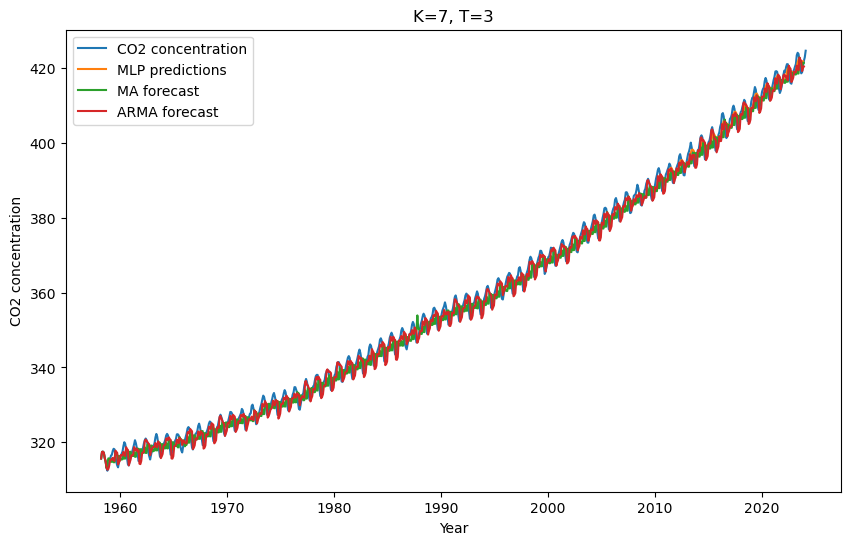

In [83]:
# plot predictions
plt.figure(figsize=(10, 6))
sns.lineplot(data=muana_df, x="decimal date", y="average", label="CO2 concentration")
sns.lineplot(data=pd.DataFrame(mlp_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MLP predictions")
# sns.lineplot(data=pd.DataFrame(ma_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MA predictions")
# sns.lineplot(data=pd.DataFrame(arma_predictions_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="ARMA predictions")
sns.lineplot(data=pd.DataFrame(ma_forecast_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="MA forecast")
sns.lineplot(data=pd.DataFrame(arma_forecast_with_decimal_date, columns=["decimal date", "average"]), x="decimal date", y="average", label="ARMA forecast")
plt.xlabel("Year")
plt.ylabel("CO2 concentration")
plt.title("K=7, T=3")
plt.legend()
plt.show()

In [82]:
# calculate the mean squared error
from sklearn.metrics import mean_squared_error

mlp_mse = mean_squared_error(Y_test[:, :, 1], mlp_predictions)
# ma_mse = mean_squared_error(muana_df["average"][train_size:], ma_predictions)
# arma_mse = mean_squared_error(muana_df["average"][train_size:], arma_predictions)

ma_mse = mean_squared_error(muana_df["average"][:max_len], ma_forecast[:max_len])
arma_mse = mean_squared_error(muana_df["average"][:max_len], arma_forecast[:max_len])

mlp_mse, ma_mse, arma_mse

(8.966912889829915, 7.108519574312798, 3.8729593762613765)